In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((400, 400)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=9216, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.alexnet(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 2506564


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


train loss:  0.12462672914019866
Val loss:  0.15259585484214452
train accuracy:  0.5638297872340425
Val accuracy:  0.43478260869565216
Best model at the moment with Val_acc 43.48, saving...
Current time: 0.999 minutes. Time expected till completion: 98.933 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:01<00:00, 14.38it/s]


train loss:  0.11316584560811174
Val loss:  0.13026225774184516
train accuracy:  0.5986460348162476
Val accuracy:  0.5217391304347826
Best model at the moment with Val_acc 52.17, saving...
Current time: 1.291 minutes. Time expected till completion: 63.261 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.10693485026087475
Val loss:  0.12229227397752845
train accuracy:  0.6179883945841392
Val accuracy:  0.5652173913043478
Best model at the moment with Val_acc 56.52, saving...
Current time: 1.599 minutes. Time expected till completion: 51.712 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:01<00:00, 14.42it/s]


train loss:  0.10169965495685084
Val loss:  0.1270235502201578
train accuracy:  0.6431334622823984
Val accuracy:  0.6
Best model at the moment with Val_acc 60.0, saving...
Current time: 1.896 minutes. Time expected till completion: 45.492 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:01<00:00, 14.07it/s]


train loss:  0.1021318762802755
Val loss:  0.1254776182382003
train accuracy:  0.6441005802707931
Val accuracy:  0.5652173913043478
Current time: 2.206 minutes. Time expected till completion: 41.913 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:01<00:00, 14.85it/s]


train loss:  0.0981340328775476
Val loss:  0.1292476853598719
train accuracy:  0.6373307543520309
Val accuracy:  0.5391304347826087
Current time: 2.508 minutes. Time expected till completion: 39.286 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:01<00:00, 11.14it/s]


train loss:  0.09411794564018397
Val loss:  0.14319616141526595
train accuracy:  0.6663442940038685
Val accuracy:  0.5304347826086957
Current time: 2.814 minutes. Time expected till completion: 37.383 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


train loss:  0.09601308108528993
Val loss:  0.15265633282454116
train accuracy:  0.6344294003868471
Val accuracy:  0.5565217391304348
Current time: 3.107 minutes. Time expected till completion: 35.725 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:01<00:00, 14.59it/s]


train loss:  0.09369308909318433
Val loss:  0.12327393267465675
train accuracy:  0.6711798839458414
Val accuracy:  0.5652173913043478
Current time: 3.396 minutes. Time expected till completion: 34.342 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  0.08866848661140962
Val loss:  0.13387228976125304
train accuracy:  0.6731141199226306
Val accuracy:  0.5565217391304348
Current time: 3.701 minutes. Time expected till completion: 33.309 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:01<00:00, 13.93it/s]


train loss:  0.08804749674388933
Val loss:  0.13940852154856143
train accuracy:  0.6876208897485493
Val accuracy:  0.5478260869565217
Current time: 4.000 minutes. Time expected till completion: 32.362 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:01<00:00, 14.97it/s]


train loss:  0.08787267449054312
Val loss:  0.11672522918037746
train accuracy:  0.688588007736944
Val accuracy:  0.6173913043478261
Best model at the moment with Val_acc 61.74, saving...
Current time: 4.306 minutes. Time expected till completion: 31.579 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:01<00:00, 14.28it/s]


train loss:  0.08288380196696324
Val loss:  0.13222793548003486
train accuracy:  0.7117988394584139
Val accuracy:  0.5565217391304348
Current time: 4.601 minutes. Time expected till completion: 30.788 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:01<00:00, 14.38it/s]


train loss:  0.0853664163406398
Val loss:  0.1491711922313856
train accuracy:  0.6924564796905223
Val accuracy:  0.5826086956521739
Current time: 4.894 minutes. Time expected till completion: 30.062 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:01<00:00, 14.55it/s]


train loss:  0.08393382541907364
Val loss:  0.12786829108777253
train accuracy:  0.690522243713733
Val accuracy:  0.591304347826087
Current time: 5.200 minutes. Time expected till completion: 29.465 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:01<00:00, 13.68it/s]


train loss:  0.08168662669464975
Val loss:  0.120512005298034
train accuracy:  0.7166344294003868
Val accuracy:  0.6
Current time: 5.495 minutes. Time expected till completion: 28.850 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.08272555866774092
Val loss:  0.12988431168639142
train accuracy:  0.7117988394584139
Val accuracy:  0.5391304347826087
Current time: 5.784 minutes. Time expected till completion: 28.239 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:01<00:00, 14.97it/s]


train loss:  0.07944431958622812
Val loss:  0.14556247825207919
train accuracy:  0.7224371373307543
Val accuracy:  0.5043478260869565
Current time: 6.075 minutes. Time expected till completion: 27.677 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:01<00:00, 14.00it/s]


train loss:  0.07930794673858343
Val loss:  0.13136110875917517
train accuracy:  0.7195357833655706
Val accuracy:  0.6
Current time: 6.364 minutes. Time expected till completion: 27.133 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:01<00:00, 14.06it/s]


train loss:  0.07899079121634854
Val loss:  0.17481923258822898
train accuracy:  0.7292069632495164
Val accuracy:  0.5304347826086957
Current time: 6.656 minutes. Time expected till completion: 26.623 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


train loss:  0.07711829874859095
Val loss:  0.13808647886566494
train accuracy:  0.7398452611218569
Val accuracy:  0.5652173913043478
Current time: 6.956 minutes. Time expected till completion: 26.169 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:01<00:00, 13.93it/s]


train loss:  0.07665090871041702
Val loss:  0.12481081148852473
train accuracy:  0.7292069632495164
Val accuracy:  0.6173913043478261
Current time: 7.264 minutes. Time expected till completion: 25.753 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


train loss:  0.07416047174591621
Val loss:  0.12492893623269123
train accuracy:  0.7427466150870407
Val accuracy:  0.5826086956521739
Current time: 7.569 minutes. Time expected till completion: 25.338 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:01<00:00, 14.41it/s]


train loss:  0.0749417760731865
Val loss:  0.15345102989155313
train accuracy:  0.7495164410058027
Val accuracy:  0.4956521739130435
Current time: 7.870 minutes. Time expected till completion: 24.921 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.0740299305988465
Val loss:  0.1312472967997841
train accuracy:  0.7379110251450677
Val accuracy:  0.5652173913043478
Current time: 8.205 minutes. Time expected till completion: 24.615 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:01<00:00, 14.07it/s]


train loss:  0.06905977468310749
Val loss:  0.1470206030037092
train accuracy:  0.7717601547388782
Val accuracy:  0.6
Current time: 8.514 minutes. Time expected till completion: 24.233 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:01<00:00, 13.91it/s]


train loss:  0.07142750006637444
Val loss:  0.21273905816285507
train accuracy:  0.7572533849129593
Val accuracy:  0.4782608695652174
Current time: 8.806 minutes. Time expected till completion: 23.807 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:01<00:00, 14.31it/s]


train loss:  0.07118060184747153
Val loss:  0.1349825514399487
train accuracy:  0.753384912959381
Val accuracy:  0.5739130434782609
Current time: 9.132 minutes. Time expected till completion: 23.483 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:01<00:00, 14.03it/s]


train loss:  0.06566330593807093
Val loss:  0.14456754793291507
train accuracy:  0.7756286266924565
Val accuracy:  0.5130434782608696
Current time: 9.433 minutes. Time expected till completion: 23.094 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:01<00:00, 13.89it/s]


train loss:  0.06538458406291109
Val loss:  0.1577158580655637
train accuracy:  0.7785299806576402
Val accuracy:  0.5826086956521739
Current time: 9.728 minutes. Time expected till completion: 22.699 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:01<00:00, 14.83it/s]


train loss:  0.06547991562512212
Val loss:  0.13843006673066513
train accuracy:  0.7736943907156673
Val accuracy:  0.6260869565217392
Best model at the moment with Val_acc 62.61, saving...
Current time: 10.036 minutes. Time expected till completion: 22.337 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


train loss:  0.06510167166129532
Val loss:  0.1459652594898058
train accuracy:  0.7872340425531915
Val accuracy:  0.5739130434782609
Current time: 10.340 minutes. Time expected till completion: 21.973 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:01<00:00, 13.86it/s]


train loss:  0.06644754714154183
Val loss:  0.1668868344763051
train accuracy:  0.7620889748549323
Val accuracy:  0.591304347826087
Current time: 10.664 minutes. Time expected till completion: 21.651 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:00<00:00, 15.16it/s]


train loss:  0.06387275334887163
Val loss:  0.16529296312643135
train accuracy:  0.7804642166344294
Val accuracy:  0.5652173913043478
Current time: 10.982 minutes. Time expected till completion: 21.318 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:01<00:00, 14.36it/s]


train loss:  0.06247835503296649
Val loss:  0.1863668836977171
train accuracy:  0.7891682785299806
Val accuracy:  0.5739130434782609
Current time: 11.301 minutes. Time expected till completion: 20.987 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:01<00:00, 14.24it/s]


train loss:  0.06172600250179579
Val loss:  0.15484920688297438
train accuracy:  0.7978723404255319
Val accuracy:  0.591304347826087
Current time: 11.617 minutes. Time expected till completion: 20.652 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:01<00:00, 14.43it/s]


train loss:  0.05878618072783232
Val loss:  0.16065595201824023
train accuracy:  0.8036750483558994
Val accuracy:  0.5565217391304348
Current time: 11.937 minutes. Time expected till completion: 20.325 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:01<00:00, 12.41it/s]


train loss:  0.06059382542088714
Val loss:  0.19579161586968796
train accuracy:  0.8017408123791102
Val accuracy:  0.5391304347826087
Current time: 12.257 minutes. Time expected till completion: 19.998 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:01<00:00, 14.32it/s]


train loss:  0.05882639603282197
Val loss:  0.1556466361750727
train accuracy:  0.816247582205029
Val accuracy:  0.6086956521739131
Current time: 12.568 minutes. Time expected till completion: 19.658 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:01<00:00, 14.06it/s]


train loss:  0.05816484342114838
Val loss:  0.14214030685632126
train accuracy:  0.8123791102514507
Val accuracy:  0.6086956521739131
Current time: 12.868 minutes. Time expected till completion: 19.301 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:01<00:00, 14.06it/s]


train loss:  0.056535644100067464
Val loss:  0.17261412947074226
train accuracy:  0.8307543520309478
Val accuracy:  0.6
Current time: 13.168 minutes. Time expected till completion: 18.948 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:01<00:00, 14.03it/s]


train loss:  0.05795075266659836
Val loss:  0.15426530838012695
train accuracy:  0.8123791102514507
Val accuracy:  0.6086956521739131
Current time: 13.493 minutes. Time expected till completion: 18.633 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:01<00:00, 12.12it/s]


train loss:  0.05622815572777385
Val loss:  0.1697483285613682
train accuracy:  0.8210831721470019
Val accuracy:  0.5217391304347826
Current time: 13.840 minutes. Time expected till completion: 18.347 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:01<00:00, 12.28it/s]


train loss:  0.05858383377441124
Val loss:  0.15442937690278757
train accuracy:  0.8075435203094777
Val accuracy:  0.591304347826087
Current time: 14.208 minutes. Time expected till completion: 18.083 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:01<00:00, 13.94it/s]


train loss:  0.05449749697972543
Val loss:  0.17845106073047803
train accuracy:  0.8230174081237911
Val accuracy:  0.48695652173913045
Current time: 14.527 minutes. Time expected till completion: 17.755 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:01<00:00, 14.95it/s]


train loss:  0.051575846843983496
Val loss:  0.15605044624079828
train accuracy:  0.8307543520309478
Val accuracy:  0.591304347826087
Current time: 14.824 minutes. Time expected till completion: 17.402 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:01<00:00, 14.48it/s]


train loss:  0.051921488803665455
Val loss:  0.15075090942175493
train accuracy:  0.8404255319148937
Val accuracy:  0.5739130434782609
Current time: 15.128 minutes. Time expected till completion: 17.059 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.0526877273400125
Val loss:  0.15251455799393032
train accuracy:  0.8230174081237911
Val accuracy:  0.6
Current time: 15.428 minutes. Time expected till completion: 16.714 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:01<00:00, 13.12it/s]


train loss:  0.049124417758080206
Val loss:  0.17225036361943122
train accuracy:  0.844294003868472
Val accuracy:  0.5826086956521739
Current time: 15.734 minutes. Time expected till completion: 16.376 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


train loss:  0.04569559200618207
Val loss:  0.16009413211242013
train accuracy:  0.8558994197292069
Val accuracy:  0.5826086956521739
Current time: 16.039 minutes. Time expected till completion: 16.039 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:01<00:00, 14.55it/s]


train loss:  0.04596993504758615
Val loss:  0.18080796262492305
train accuracy:  0.8558994197292069
Val accuracy:  0.591304347826087
Current time: 16.365 minutes. Time expected till completion: 15.724 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:01<00:00, 14.15it/s]


train loss:  0.04519333885676395
Val loss:  0.16799416749373727
train accuracy:  0.844294003868472
Val accuracy:  0.591304347826087
Current time: 16.673 minutes. Time expected till completion: 15.391 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:01<00:00, 14.70it/s]


train loss:  0.048150910857193016
Val loss:  0.17382137619930765
train accuracy:  0.8529980657640233
Val accuracy:  0.591304347826087
Current time: 16.985 minutes. Time expected till completion: 15.062 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:01<00:00, 12.64it/s]


train loss:  0.048304590574921445
Val loss:  0.1801629162353018
train accuracy:  0.8404255319148937
Val accuracy:  0.5739130434782609
Current time: 17.293 minutes. Time expected till completion: 14.731 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:01<00:00, 14.20it/s]


train loss:  0.04533653674247302
Val loss:  0.16893882557101872
train accuracy:  0.8549323017408124
Val accuracy:  0.5826086956521739
Current time: 17.598 minutes. Time expected till completion: 14.398 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:01<00:00, 14.35it/s]


train loss:  0.045097383805613685
Val loss:  0.17355312860530356
train accuracy:  0.8549323017408124
Val accuracy:  0.5478260869565217
Current time: 17.898 minutes. Time expected till completion: 14.062 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:01<00:00, 14.52it/s]


train loss:  0.04503039998404062
Val loss:  0.16607732306356016
train accuracy:  0.8626692456479691
Val accuracy:  0.5652173913043478
Current time: 18.187 minutes. Time expected till completion: 13.720 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


train loss:  0.0434114154008518
Val loss:  0.1839921137560969
train accuracy:  0.8626692456479691
Val accuracy:  0.5826086956521739
Current time: 18.483 minutes. Time expected till completion: 13.384 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.04414862259768483
Val loss:  0.19236123872839886
train accuracy:  0.867504835589942
Val accuracy:  0.5043478260869565
Current time: 18.798 minutes. Time expected till completion: 13.063 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:01<00:00, 14.57it/s]


train loss:  0.04146944895761386
Val loss:  0.1894262705160224
train accuracy:  0.8713733075435203
Val accuracy:  0.5652173913043478
Current time: 19.108 minutes. Time expected till completion: 12.739 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


train loss:  0.042398830583618326
Val loss:  0.17562306017979332
train accuracy:  0.8520309477756286
Val accuracy:  0.5565217391304348
Current time: 19.443 minutes. Time expected till completion: 12.431 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


train loss:  0.040151978167389996
Val loss:  0.1932095458974009
train accuracy:  0.8617021276595744
Val accuracy:  0.591304347826087
Current time: 19.780 minutes. Time expected till completion: 12.123 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:02<00:00,  6.01it/s]


train loss:  0.04069492094060208
Val loss:  0.1862382049145906
train accuracy:  0.8762088974854932
Val accuracy:  0.5478260869565217
Current time: 20.109 minutes. Time expected till completion: 11.810 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:01<00:00, 14.64it/s]


train loss:  0.039933072871436694
Val loss:  0.17937389391919842
train accuracy:  0.8694390715667312
Val accuracy:  0.5826086956521739
Current time: 20.419 minutes. Time expected till completion: 11.486 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:01<00:00, 14.08it/s]


train loss:  0.038644169075360495
Val loss:  0.23141361837801727
train accuracy:  0.8781431334622823
Val accuracy:  0.5478260869565217
Current time: 20.737 minutes. Time expected till completion: 11.166 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:01<00:00, 12.70it/s]


train loss:  0.0424338690468202
Val loss:  0.17980078679064046
train accuracy:  0.8578336557059961
Val accuracy:  0.5739130434782609
Current time: 21.062 minutes. Time expected till completion: 10.850 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


train loss:  0.04002874306217556
Val loss:  0.26036452936089555
train accuracy:  0.874274661508704
Val accuracy:  0.5130434782608696
Current time: 21.372 minutes. Time expected till completion: 10.526 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:01<00:00, 13.86it/s]


train loss:  0.040664340853979325
Val loss:  0.19846522859905077
train accuracy:  0.8626692456479691
Val accuracy:  0.591304347826087
Current time: 21.679 minutes. Time expected till completion: 10.202 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:01<00:00, 14.28it/s]


train loss:  0.03697476925137426
Val loss:  0.18233255173849022
train accuracy:  0.8945841392649904
Val accuracy:  0.5304347826086957
Current time: 22.001 minutes. Time expected till completion: 9.884 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.03681902090228042
Val loss:  0.24455129374628481
train accuracy:  0.8878143133462283
Val accuracy:  0.5043478260869565
Current time: 22.306 minutes. Time expected till completion: 9.560 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:01<00:00, 13.04it/s]


train loss:  0.03695210163376321
Val loss:  0.21909619958504387
train accuracy:  0.8694390715667312
Val accuracy:  0.5652173913043478
Current time: 22.635 minutes. Time expected till completion: 9.245 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:01<00:00, 13.40it/s]


train loss:  0.0338367086238943
Val loss:  0.22027302008608113
train accuracy:  0.8945841392649904
Val accuracy:  0.6173913043478261
Current time: 22.976 minutes. Time expected till completion: 8.935 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


train loss:  0.03745825837144035
Val loss:  0.1950935203096141
train accuracy:  0.8858800773694391
Val accuracy:  0.5565217391304348
Current time: 23.301 minutes. Time expected till completion: 8.618 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.03518970598351869
Val loss:  0.22956769259079643
train accuracy:  0.8936170212765957
Val accuracy:  0.5478260869565217
Current time: 23.610 minutes. Time expected till completion: 8.296 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.03433347025767286
Val loss:  0.21288046344466832
train accuracy:  0.9052224371373307
Val accuracy:  0.5565217391304348
Current time: 23.923 minutes. Time expected till completion: 7.974 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


train loss:  0.03260167107540876
Val loss:  0.21910820914351423
train accuracy:  0.8955512572533849
Val accuracy:  0.4956521739130435
Current time: 24.270 minutes. Time expected till completion: 7.664 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


train loss:  0.031140077798816463
Val loss:  0.2073706663173178
train accuracy:  0.9013539651837524
Val accuracy:  0.5391304347826087
Current time: 24.586 minutes. Time expected till completion: 7.344 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


train loss:  0.032466595156597444
Val loss:  0.21109606273796247
train accuracy:  0.8974854932301741
Val accuracy:  0.5565217391304348
Current time: 24.902 minutes. Time expected till completion: 7.024 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:01<00:00, 11.17it/s]


train loss:  0.03252654775753761
Val loss:  0.24602404055388077
train accuracy:  0.9013539651837524
Val accuracy:  0.5304347826086957
Current time: 25.233 minutes. Time expected till completion: 6.707 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


train loss:  0.03166325196193268
Val loss:  0.20797828099002008
train accuracy:  0.8984526112185687
Val accuracy:  0.591304347826087
Current time: 25.559 minutes. Time expected till completion: 6.390 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:01<00:00, 11.81it/s]


train loss:  0.031208979264910494
Val loss:  0.22862028868302056
train accuracy:  0.8994197292069632
Val accuracy:  0.5826086956521739
Current time: 25.891 minutes. Time expected till completion: 6.073 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:01<00:00, 12.97it/s]


train loss:  0.028737978448612145
Val loss:  0.2362287428068078
train accuracy:  0.9206963249516441
Val accuracy:  0.6
Current time: 26.220 minutes. Time expected till completion: 5.756 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:01<00:00, 10.72it/s]


train loss:  0.03381473268247146
Val loss:  0.2558476622985757
train accuracy:  0.8897485493230174
Val accuracy:  0.48695652173913045
Current time: 26.541 minutes. Time expected till completion: 5.436 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:01<00:00, 14.53it/s]


train loss:  0.027862893965102487
Val loss:  0.2963527765610944
train accuracy:  0.9264990328820116
Val accuracy:  0.5565217391304348
Current time: 26.848 minutes. Time expected till completion: 5.114 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.030822222121059895
Val loss:  0.29810483740723653
train accuracy:  0.9119922630560928
Val accuracy:  0.48695652173913045
Current time: 27.156 minutes. Time expected till completion: 4.792 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


train loss:  0.03304584771106506
Val loss:  0.23370629134385482
train accuracy:  0.9100580270793037
Val accuracy:  0.5652173913043478
Current time: 27.462 minutes. Time expected till completion: 4.471 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.031987947744643405
Val loss:  0.252116334438324
train accuracy:  0.8984526112185687
Val accuracy:  0.5130434782608696
Current time: 27.778 minutes. Time expected till completion: 4.151 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:01<00:00, 14.32it/s]


train loss:  0.028176271048335855
Val loss:  0.22885559965734897
train accuracy:  0.9148936170212766
Val accuracy:  0.5565217391304348
Current time: 28.086 minutes. Time expected till completion: 3.830 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:01<00:00, 14.57it/s]


train loss:  0.030390887732871553
Val loss:  0.22968269949373993
train accuracy:  0.9129593810444874
Val accuracy:  0.5739130434782609
Current time: 28.385 minutes. Time expected till completion: 3.508 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


train loss:  0.02771809972494812
Val loss:  0.23706567734479905
train accuracy:  0.9168278529980658
Val accuracy:  0.5826086956521739
Current time: 28.736 minutes. Time expected till completion: 3.193 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:01<00:00, 13.00it/s]


train loss:  0.02792129621163688
Val loss:  0.2447710757670195
train accuracy:  0.9090909090909091
Val accuracy:  0.5826086956521739
Current time: 29.060 minutes. Time expected till completion: 2.874 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:01<00:00, 13.36it/s]


train loss:  0.025862462526570998
Val loss:  0.2502332179442696
train accuracy:  0.9216634429400387
Val accuracy:  0.5478260869565217
Current time: 29.369 minutes. Time expected till completion: 2.554 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:01<00:00, 12.08it/s]


train loss:  0.023887775549250773
Val loss:  0.2622968375682831
train accuracy:  0.9264990328820116
Val accuracy:  0.5478260869565217
Current time: 29.685 minutes. Time expected till completion: 2.234 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:01<00:00, 10.85it/s]


train loss:  0.02798637435582378
Val loss:  0.38468936785407687
train accuracy:  0.9197292069632496
Val accuracy:  0.46956521739130436
Current time: 30.061 minutes. Time expected till completion: 1.919 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:01<00:00, 14.23it/s]


train loss:  0.03076053350646863
Val loss:  0.2749436046766198
train accuracy:  0.9052224371373307
Val accuracy:  0.5217391304347826
Current time: 30.391 minutes. Time expected till completion: 1.600 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.026423448320240416
Val loss:  0.27274425444395645
train accuracy:  0.9332688588007737
Val accuracy:  0.5391304347826087
Current time: 30.703 minutes. Time expected till completion: 1.279 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:01<00:00, 14.80it/s]


train loss:  0.024277609680658584
Val loss:  0.24220874076304227
train accuracy:  0.9235976789168279
Val accuracy:  0.5652173913043478
Current time: 31.001 minutes. Time expected till completion: 0.959 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.023140035492658067
Val loss:  0.25962289105290953
train accuracy:  0.9361702127659575
Val accuracy:  0.5478260869565217
Current time: 31.321 minutes. Time expected till completion: 0.639 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:01<00:00, 13.84it/s]


train loss:  0.02223179385546105
Val loss:  0.2531627940094989
train accuracy:  0.9381044487427466
Val accuracy:  0.5478260869565217
Current time: 31.658 minutes. Time expected till completion: 0.320 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:01<00:00, 10.99it/s]


train loss:  0.023211284325993335
Val loss:  0.26796387744986494
train accuracy:  0.9294003868471954
Val accuracy:  0.5652173913043478
Saving model 2 checkpoint


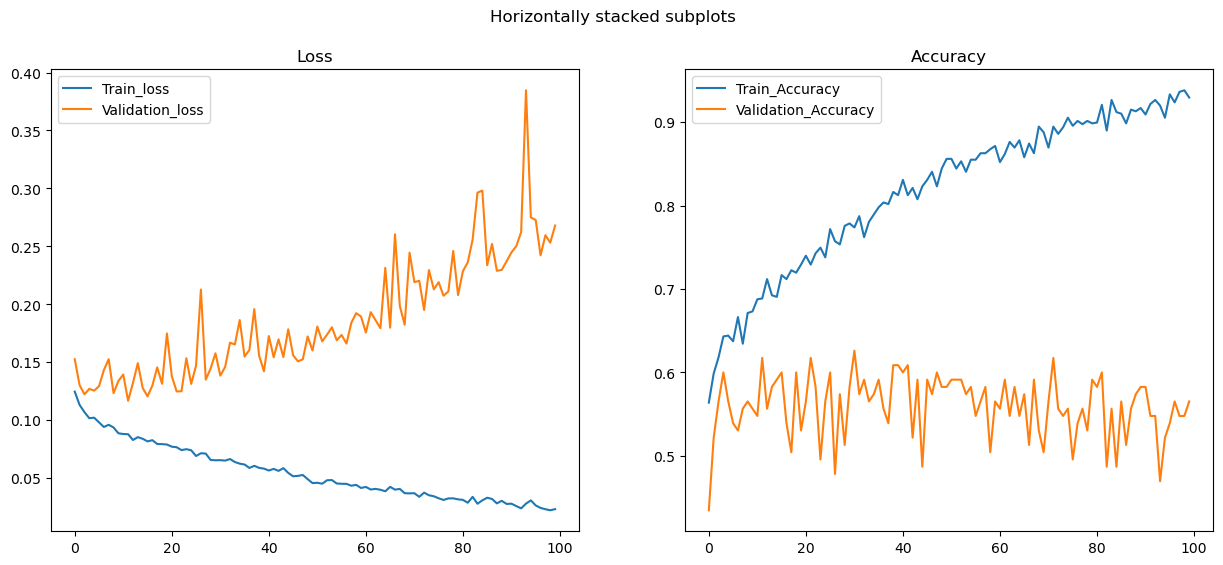

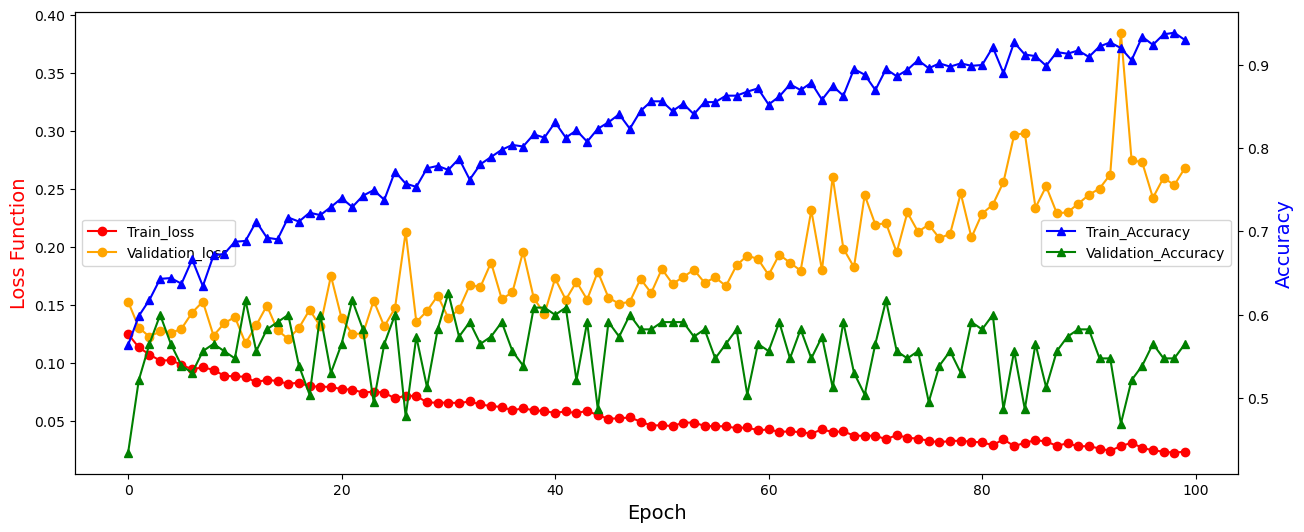

Current time: 32.201 minutes. Time expected till completion: 0.000 minutes
Finished training in: 32.201 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.6260869565217392

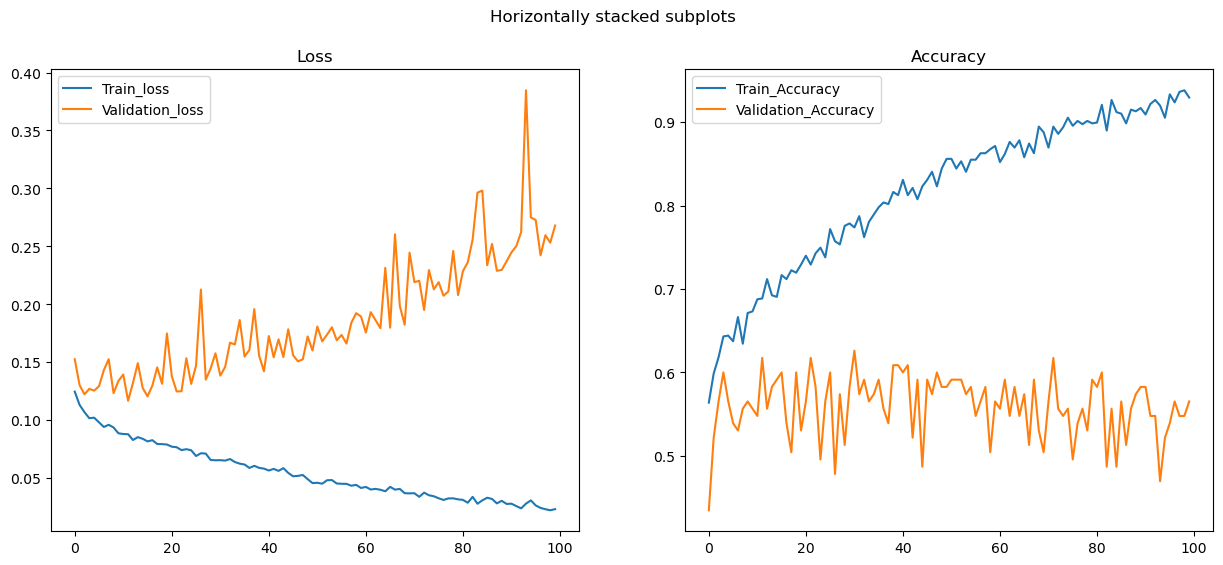

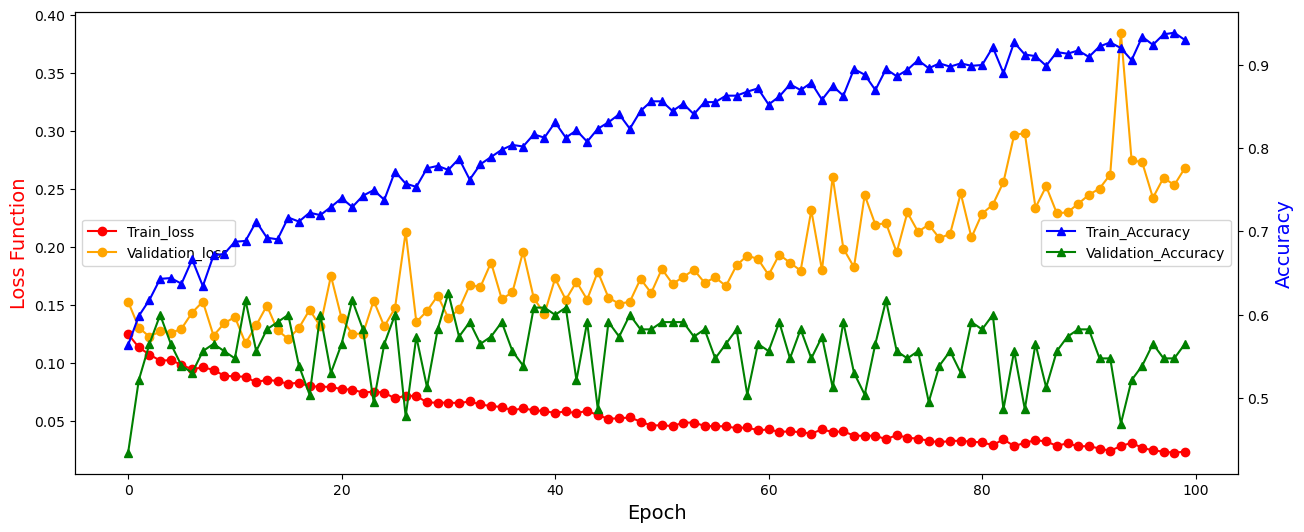

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:10<00:00, 12.39it/s]


Accuracy of the network on the 1034 Train instances: 94.58413926499033%


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]

Accuracy of the network on the 115 Validation instances: 56.52173913043478%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:10<00:00, 35.32it/s]


(array([0, 1, 2, 3]), array([147, 181,  48,   4], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_AlexNet_prediction.csv")

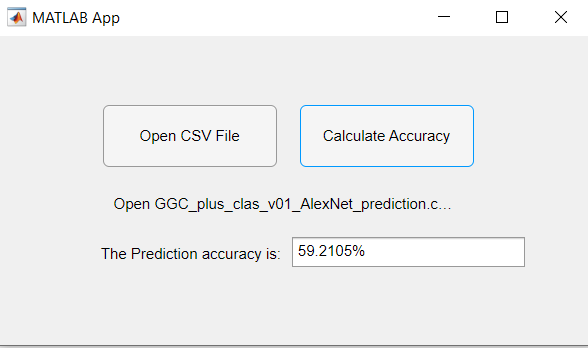

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (last_classifier): Linear

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:10<00:00, 12.15it/s]


Accuracy of the network on the 1034 Train instances: 80.4642166344294%


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]

Accuracy of the network on the 115 Validation instances: 62.608695652173914%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:04<00:00, 86.52it/s]


(array([0, 1, 2, 3]), array([164, 164,  50,   2], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_AlexNet_best_prediction.csv")

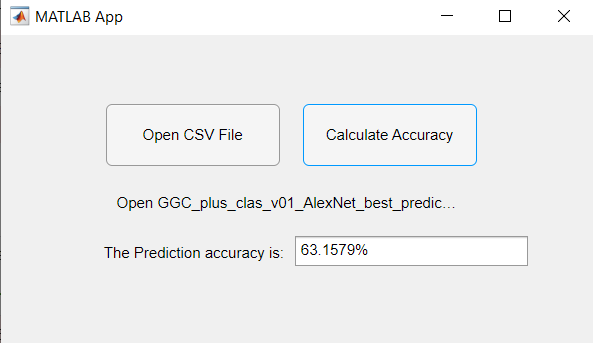